In [176]:
import joblib
import numpy as np
import glob
from importlib import reload
from PIL import Image
import msi_visual
from msi_visual import nmf_segmentation, kmeans_segmentation
reload(nmf_segmentation)
reload(kmeans_segmentation)

paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\\*.npy")
paths = [paths[1]]
seg = kmeans_segmentation.KmeansSegmentation(k=50, normalization='tic', start_bin=0, end_bin=5005)
images = [np.load(p)[::2, ::2, :] for p in paths]
seg.fit(images)

#joblib.dump(seg, "models/slide2_timson_15.joblib")

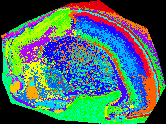

In [177]:
#seg = joblib.load(open("models/slide2_timson_15.joblib", "rb"))
for img in seg.visualize_training_components(images):
    display(Image.fromarray(img))

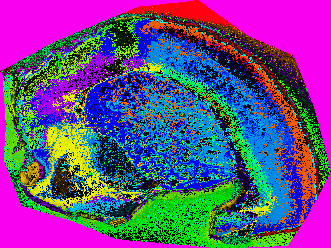

In [178]:
for path in paths:
    mask, viz = seg.predict(np.load(path), method='spatial_norm')
    display(Image.fromarray(viz))

0.0 0.1715197 0.99999464


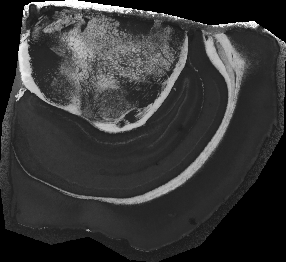

0.0 0.16031966 0.9999972


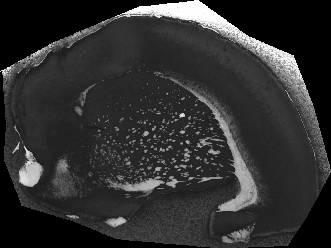

0.0 0.15727258 0.9999912


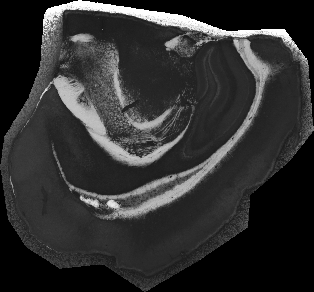

0.0 0.1655032 0.9999953


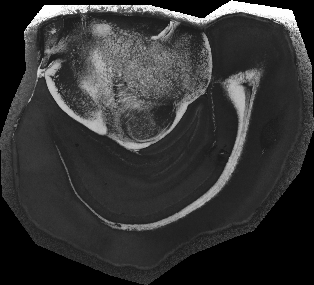

In [179]:
import scipy
from scipy.stats import entropy
paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\\*.npy")
for path in paths:
    #mask = seg.predict(np.load(path), method='spatial_norm')
    img = np.load(path)
    mask = seg.factorize(img)
    e = entropy(mask, axis=0, base=mask.shape[0])
    e = 1 - e
    e[img.max(axis=-1) == 0] = 0
    print(e.min(), np.median(e), np.max(e))
    display(Image.fromarray(np.uint8(255*e)))
    
    

In [180]:
path = paths[0]
img = np.load(path)
mask, viz = seg.predict(img, method='spatial_norm')
display(Image.fromarray(viz))

KeyboardInterrupt: 

In [ ]:
import scipy
from msi_visual.normalization import spatial_total_ion_count, total_ion_count, median_ion
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.stats import entropy
import random

nrow, ncol = img.shape[0], img.shape[1]
points = np.mgrid[:nrow,:ncol].reshape(2, -1).T

indices = points

normalized = spatial_total_ion_count(img)

inputs, outputs = [], []
mask = seg.factorize(img)
e = entropy(mask, axis=0, base=mask.shape[0])
e = 1 - e
indices = list(indices)

for _ in range(500):
    point_a = random.choice(indices)
    point_b = random.choice(indices)
    #point_a, point_b = sample[a], sample[b]
    a, b = normalized[point_a[0], point_a[1]], normalized[point_b[0], point_b[1]]

    similarity = np.linalg.norm(a-b, 2)

    # similarity = 1 - cosine_similarity(np.array([a]), np.array([b]))[0, 0]
    # if np.isnan(similarity):
    #     continue


    #input_distance = np.linalg.norm(a-b, 2)
    input_distance = similarity



    a, b = viz[point_a[0], point_a[1]], viz[point_b[0], point_b[1]]

    output_distance = np.linalg.norm(a-b, 2)
    #output_distance = a -b

    inputs.append(input_distance)
    outputs.append(output_distance)
corr = scipy.stats.pearsonr(inputs, outputs).statistic



print(corr)
    



0.1562576879139717


In [ ]:
a, b = normalized[point_a[0], point_a[1]], normalized[point_b[0], point_b[1]]
print(np.linalg.norm(a-b, 2))

239963.44


In [ ]:
e.shape

(262, 286)

In [ ]:
import scipy
from msi_visual.normalization import spatial_total_ion_count, total_ion_count, median_ion
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.stats import entropy
import random

paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\\*.npy")
path = paths[2]

img = np.load(path)
normalized = spatial_total_ion_count(img)

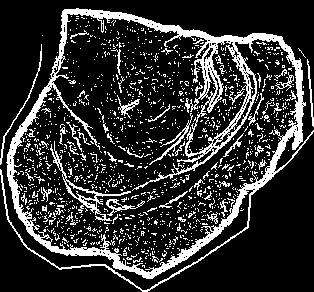

In [ ]:
import cv2

sobel_h = scipy.ndimage.sobel(normalized, 0)  # horizontal gradient
sobel_v = scipy.ndimage.sobel(normalized, 1)  # vertical gradient
magnitude = np.sqrt(sobel_h**2 + sobel_v**2)

#magnitude = magnitude / (1e-5 + np.max(magnitude, axis=(0, 1)))
magnitude = magnitude.max(axis=-1)

p = np.percentile(magnitude, 96, axis=(0, 1))
magnitude = magnitude / p
magnitude[magnitude > 1] = 1
magnitude1 = np.uint8(magnitude * 255)

#magnitude1 = cv2.equalizeHist(magnitude1)

_, thresh1 = cv2.threshold(magnitude1, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

display(Image.fromarray(thresh1))

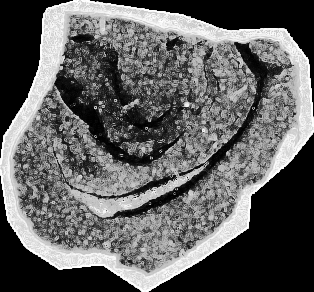

In [ ]:
sobel_h = scipy.ndimage.sobel(normalized, 0)  # horizontal gradient
sobel_v = scipy.ndimage.sobel(normalized, 1)  # vertical gradient
magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
magnitude = np.median(magnitude, axis=-1)
p = np.percentile(magnitude, 99, axis=(0, 1))
magnitude = magnitude / p
magnitude[magnitude > 1] = 1
magnitude2 = np.uint8(magnitude * 255)

magnitude2 = cv2.equalizeHist(magnitude2)

#_, magnitude2 = cv2.threshold(magnitude2, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


display(Image.fromarray(magnitude2))

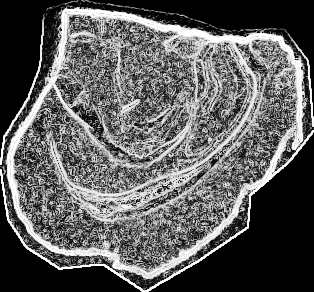

In [ ]:
sobel_h = scipy.ndimage.sobel(normalized, 0)  # horizontal gradient
sobel_v = scipy.ndimage.sobel(normalized, 1)  # vertical gradient
magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
magnitude = np.percentile(magnitude, 99, axis=-1)
p = np.percentile(magnitude, 96, axis=(0, 1))
magnitude = magnitude / p
magnitude[magnitude > 1] = 1
magnitude3 = np.uint8(magnitude * 255)

magnitude3 = cv2.equalizeHist(magnitude3)

display(Image.fromarray(magnitude3))

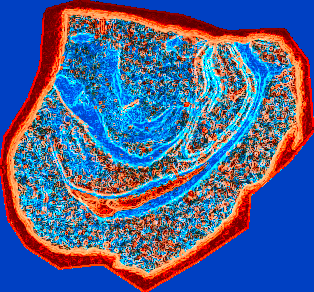

In [ ]:
a = cv2.merge([magnitude1, magnitude2, magnitude3])
a = cv2.cvtColor(a, cv2.COLOR_LAB2RGB)
Image.fromarray(a)

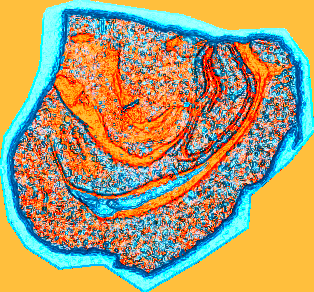

In [ ]:
Image.fromarray(255 - a)

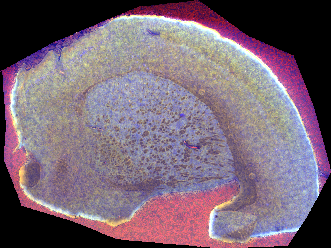

In [ ]:
novel = np.percentile(normalized, 99.9, axis=-1) / (1e-5 + np.percentile(normalized, 99, axis=-1))
novel = novel / np.percentile(novel, 99)
novel[novel > 1] = 1


mz = np.arange(normalized.shape[-1])
mz = mz[None, None, :]
avgmz = (normalized * mz).mean(axis=-1)
avgmz = avgmz / (1e-5 + np.percentile(avgmz, 99))
avgmz[avgmz > 1] = 1

stdmz = (normalized * mz).std(axis=-1)
stdmz = stdmz / (1e-5 + np.percentile(stdmz, 99))
stdmz[stdmz > 1] = 1

visualization = cv2.merge([avgmz, stdmz, novel])


Image.fromarray(np.uint8(255 * visualization))

#Image.fromarray(np.uint8(255 * novel))

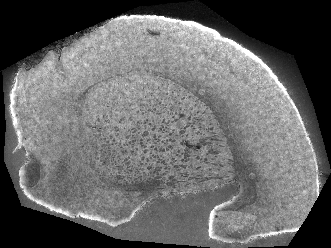

In [ ]:
mz = np.arange(normalized.shape[-1])
mz = mz[None, None, :]
avgmz = (normalized * mz).std(axis=-1)
avgmz = avgmz / (1e-5 + np.percentile(avgmz, 99))
avgmz[avgmz > 1] = 1

display(Image.fromarray(np.uint8(255*avgmz)))

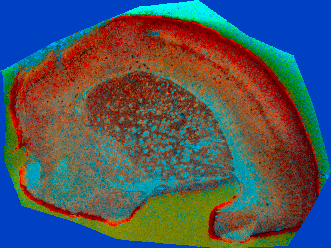

In [436]:
ratio = stdmz / (1e-5 + avgmz)
ratio = ratio / (1e-5 + np.percentile(ratio, 99))
ratio[ratio > 1] = 1
visualization = cv2.merge([(np.uint8(255*novel)), (np.uint8(255*stdmz/1)), (np.uint8(255*avgmz/1))])
visualization = cv2.cvtColor(visualization, cv2.COLOR_Lab2RGB)

display(Image.fromarray(visualization))



In [233]:
novel

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

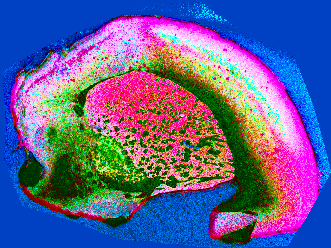

In [273]:
a = np.percentile(normalized, 99.99, axis=-1) / (1e-5 + np.percentile(normalized, 99.9, axis=-1))
a = a / np.percentile(a, 99.9)
a[a > 1] = 1

b = np.percentile(normalized, 99.9, axis=-1) / (1e-5 + np.percentile(normalized, 99, axis=-1))
b = b / np.percentile(b, 99.9)
b[b > 1] = 1

c = np.percentile(normalized, 98, axis=-1) / (1e-5 + np.percentile(normalized, 90, axis=-1))
c = c / np.percentile(c, 99.9)
c[c > 1] = 1

visualization = cv2.merge([(np.uint8(255*a)), (np.uint8(255*b)), (np.uint8(255*c))])
visualization = cv2.cvtColor(visualization, cv2.COLOR_LAB2LRGB)
display(Image.fromarray(visualization))

In [209]:
a = np.percentile(normalized, 99.9, axis=-1) / (1e-5 + np.percentile(normalized, 99, axis=-1))
a = a / np.percentile(a, 99.9)
a[a > 1] = 1


visualization = cv2.merge([cv2.equalizeHist(np.uint8(255*a)), cv2.equalizeHist(np.uint8(255*a)), cv2.equalizeHist(np.uint8(255*a))])
visualization = cv2.cvtColor(visualization, cv2.COLOR_Lab2RGB)
display(Image.fromarray(visualization))

TypeError: 'module' object is not callable

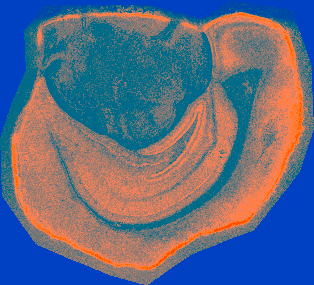

In [219]:
visualization = cv2.merge([(np.uint8(255*b)), (np.uint8(255*b)), (np.uint8(255*b))])
visualization = cv2.cvtColor(visualization, cv2.COLOR_Lab2RGB)
display(Image.fromarray(visualization))

In [31]:
def get_edges(normalized):
    sobel_h = scipy.ndimage.sobel(normalized, 0)  # horizontal gradient
    sobel_v = scipy.ndimage.sobel(normalized, 1)  # vertical gradient
    magnitude = np.sqrt(sobel_h**2 + sobel_v**2)

    #magnitude = magnitude / (1e-5 + np.max(magnitude, axis=(0, 1)))
    magnitude = magnitude.max(axis=-1)

    p = np.percentile(magnitude, 96, axis=(0, 1))
    magnitude = magnitude / p
    magnitude[magnitude > 1] = 1
    magnitude1 = np.uint8(magnitude * 255)
    #magnitude1 = cv2.equalizeHist(magnitude1)
    return magnitude1

def get_rare(normalized, high=99.9, low=99):
    novel = np.percentile(normalized, high, axis=-1) / (1e-5 + np.percentile(normalized, low, axis=-1))
    novel = novel / np.percentile(novel, 99)
    novel[novel > 1] = 1
    return np.uint8(255*novel)

# novel = get_rare(normalized)
# edges = get_edges(normalized)

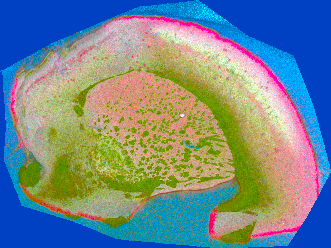

In [435]:
visualization = cv2.merge([(np.uint8(255*a)), (np.uint8(255*b)), (np.uint8(255*c))])
visualization = cv2.cvtColor(visualization, cv2.COLOR_LAB2RGB)
display(Image.fromarray(visualization))

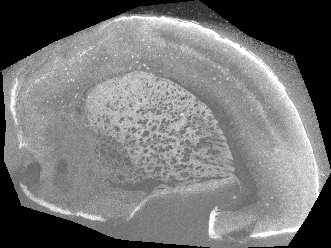

In [449]:
visualization = cv2.merge([novel, novel, novel])
#visualization = cv2.cvtColor(visualization, cv2.COLOR_LAB2RGB)
display(Image.fromarray(visualization))

In [450]:
novel2 = get_rare(img)

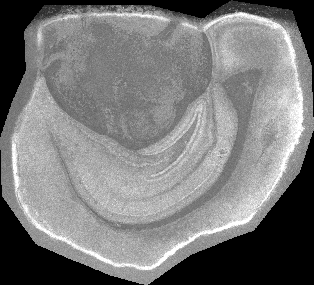

In [451]:
display(Image.fromarray(novel2))

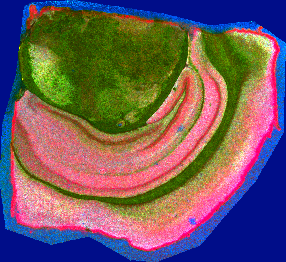

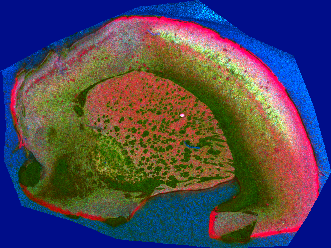

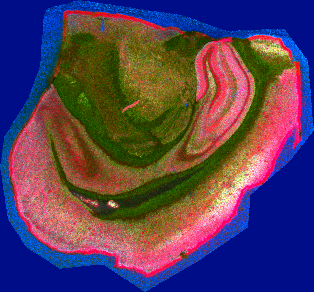

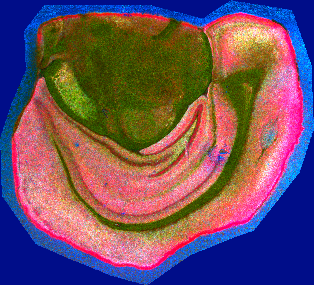

In [35]:
import cv2

paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\\*.npy")
for path in paths:
    img = np.load(path)
    #normalized = spatial_total_ion_count(img)
    normalized = img

    a = np.percentile(normalized, 99.99, axis=-1) / (1e-5 + np.percentile(normalized, 99.9, axis=-1))
    a = a / np.percentile(a, 99.9)
    a[a > 1] = 1

    b = np.percentile(normalized, 99.9, axis=-1) / (1e-5 + np.percentile(normalized, 99, axis=-1))
    b = b / np.percentile(b, 99.9)
    b[b > 1] = 1

    c = np.percentile(normalized, 98, axis=-1) / (1e-5 + np.percentile(normalized, 90, axis=-1))
    c = c / np.percentile(c, 99.9)
    c[c > 1] = 1

    visualization = cv2.merge([(np.uint8(255*a)), (np.uint8(255*b)), (np.uint8(255*c))])
    visualization = cv2.cvtColor(visualization, cv2.COLOR_LAB2LRGB)
    display(Image.fromarray(visualization))

norm took 41.948949575424194
took 14.919653415679932


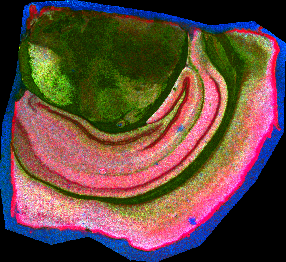

norm took 56.02813649177551
took 15.917930126190186


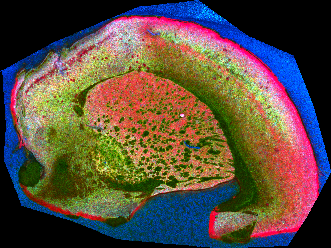

norm took 64.69508385658264
took 38.20245432853699


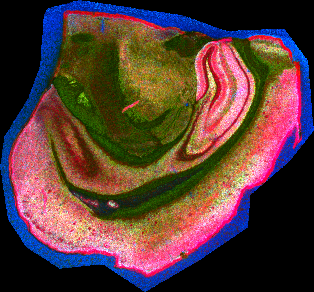

norm took 53.334288358688354
took 15.238873481750488


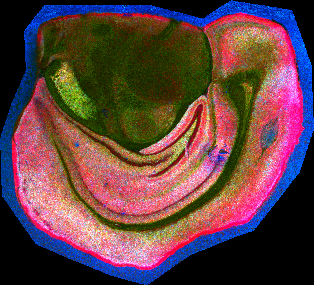

In [1]:
import cv2
import time
import glob
import numpy as np
import time
import cv2
from PIL import Image
from msi_visual.normalization import spatial_total_ion_count, total_ion_count, median_ion

paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\\*.npy")
for index, path in enumerate(paths):
    img = np.load(path)
    normalized = spatial_total_ion_count(img)
    #normalized = img

    t0 = time.time()
    sorted_normalized = np.sort(normalized, axis=-1)
    N = sorted_normalized.shape[-1]

    p_9999 = sorted_normalized[:, :, int(N*99.99/100)]
    p_999 = sorted_normalized[:, :, int(N*99.9/100)]
    p_99 = sorted_normalized[:, :, int(N*99/100)]
    p_98 = sorted_normalized[:, :, int(N*98/100)]
    p_85 = sorted_normalized[:, :, int(N*85/100)]


    a = p_9999 / (1e-5 + p_999)
    a = a / np.percentile(a, 99.9)
    a[a > 1] = 1

    b = p_999 / (1e-5 + p_99)
    b = b / np.percentile(b, 99.9)
    b[b > 1] = 1

    c = p_98 / (1e-5 + p_85)
    c = c / np.percentile(c, 99.9)
    c[c > 1] = 1

    visualization = cv2.merge([(np.uint8(255*a)), (np.uint8(255*b)), (np.uint8(255*c))])

    visualization = cv2.cvtColor(visualization, cv2.COLOR_LAB2LRGB)
    visualization[img.max(axis=-1) == 0] = 0
    Image.fromarray(visualization).save(f"{index}_rare.png")

    print("took", time.time()-t0)
    display(Image.fromarray(visualization))

In [68]:
normalized = spatial_total_ion_count(img)


took 0.28003525733947754


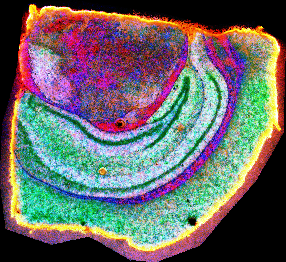

took 0.24900078773498535


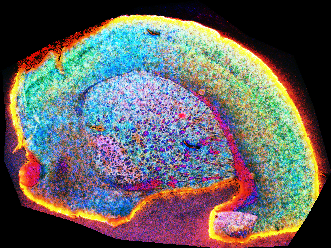

took 0.26996302604675293


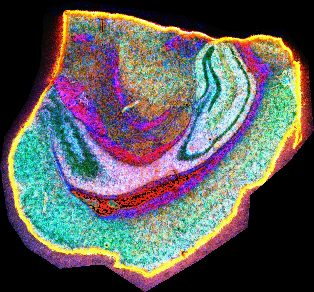

took 0.32103562355041504


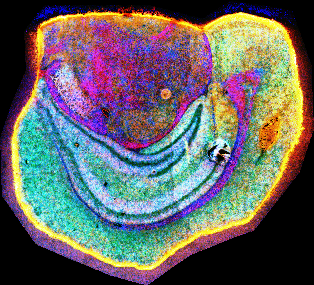

In [148]:
import cv2
import scipy
import time
paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\\*.npy")

def get_max_img(normalized):
    N = normalized.shape[-1] // 3
    a = normalized[:, :, :N].max(axis=-1)
    b = normalized[:, :, N:N+N].max(axis=-1)
    c = normalized[:, :, N+N:].max(axis=-1)
    
    a = a - a.min()
    a = a / np.percentile(a, 99.9)
    a[a > 1] = 1    

    b = b - b.min()
    b = b / np.percentile(b, 99.9)
    b[b > 1] = 1

    c = c - c.min()
    c = c / np.percentile(c, 99.9)
    c[c > 1] = 1

    a = np.uint8(255*a)
    b = np.uint8(255*b)
    c = np.uint8(255*c)
    
    visualization = cv2.merge([cv2.equalizeHist(a), cv2.equalizeHist(b), cv2.equalizeHist(c)])    
    return visualization

def get_mz(normalized):
    mz = np.arange(normalized.shape[-1])
    mz = mz[None, None, :]
    avgmz = ((normalized/(1e-5+normalized.sum(axis=-1)[:, :, None] )) * mz).mean(axis=-1)
    return avgmz


for path in paths:
    img = np.load(path)
    t0 = time.time()
    #normalized = spatial_total_ion_count(img)
    normalized = img
    
    visualization = get_max_img(normalized)

    print("took", time.time()-t0)
    display(Image.fromarray(visualization))

d:\miniconda3\envs\dl\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


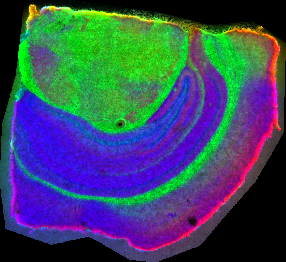

d:\miniconda3\envs\dl\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


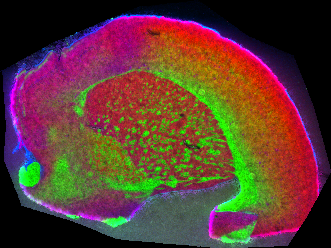

d:\miniconda3\envs\dl\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


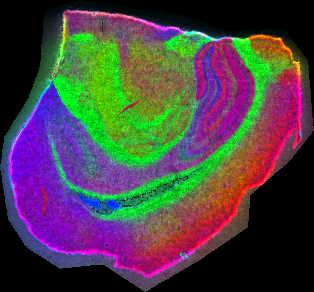

d:\miniconda3\envs\dl\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


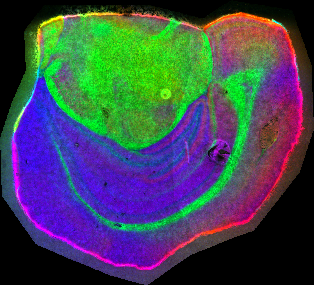

In [157]:
from sklearn.decomposition import NMF
from PIL import Image

def normalize_channel(channel):
    channel = channel / np.percentile(channel, 99)
    channel[channel > 1] = 1
    return channel


for index, path in enumerate(paths):
    img = np.load(path)
    t0 = time.time()
    normalized = spatial_total_ion_count(img)
    
    model = NMF(n_components=3, init='random', random_state=0)
    vector = normalized.reshape(-1, normalized.shape[-1])
    W = model.fit_transform(vector)
    output = W.reshape((normalized.shape[0], normalized.shape[1], 3))

    output[:, :, 0] = normalize_channel(output[:, :, 0])
    output[:, :, 1] = normalize_channel(output[:, :, 1])
    output[:, :, 2] = normalize_channel(output[:, :, 2])
    
    output = np.uint8(255 * output)
    display(Image.fromarray(output))
    Image.fromarray(output).save(f"nmf_{index}.png")
    







    


In [3]:
import scipy
from msi_visual.normalization import spatial_total_ion_count, total_ion_count, median_ion
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import random
import glob
import numpy as np
paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\\*.npy")
path = paths[2]

img = np.load(path)
mask = img.sum(axis=-1) > 0
img = img / (1e-6 + np.sum(img, axis=-1)[:, :, None] )
vector = img[mask > 0]
indices = list(range(vector.shape[0]))
indices = np.random.choice(indices, size=10000)
vector = vector[indices, :]
print(vector.shape)


(10000, 5255)


In [4]:
img_vector = img.reshape(-1, img.shape[-1])
cosine_average_img = 1-cosine_similarity(img_vector, vector).mean(axis=-1).reshape(img.shape[:2])
cosine_average_img[mask==0] = 0


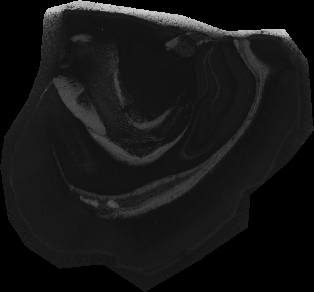

In [25]:
from PIL import Image
Image.fromarray(np.uint8(255*cosine_average_img))

from scipy.linalg import norm
norm(

In [9]:
from sklearn.metrics.pairwise import pairwise_distances
max_diff = pairwise_distances(img_vector, vector, metric='sqeuclidean')
print(max_diff.shape)

KeyboardInterrupt: 

In [ ]:
from sklearn.decomposition import NMF
from PIL import Image

def normalize_channel(channel):
    channel = channel / np.percentile(channel, 99)
    channel[channel > 1] = 1
    return channel


for index, path in enumerate(paths):
    img = np.load(path)
    t0 = time.time()
    normalized = spatial_total_ion_count(img)
    
    model = NMF(n_components=3, init='random', random_state=0)
    vector = normalized.reshape(-1, normalized.shape[-1])
    W = model.fit_transform(vector)
    output = W.reshape((normalized.shape[0], normalized.shape[1], 3))

    output[:, :, 0] = normalize_channel(output[:, :, 0])
    output[:, :, 1] = normalize_channel(output[:, :, 1])
    output[:, :, 2] = normalize_channel(output[:, :, 2])
    
    output = np.uint8(255 * output)
    display(Image.fromarray(output))
    Image.fromarray(output).save(f"nmf_{index}.png")
    







    
